In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


2025-05-25 17:36:27.676916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748194587.879015      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748194587.936923      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tf.random.set_seed(42)

# Paths (adjust according to your dataset structure)
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Image settings
IMG_SIZE = 227
BATCH_SIZE = 32
NUM_CLASSES = 4

# 1. Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

# 2. Model Definition (Based on Paper)
model = Sequential([
    Conv2D(128, (6, 6), strides=(2, 2), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(96, (6, 6), padding='same'),
    # BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(96, (3, 3), padding='same'),
    # BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

# 3. Compilation
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    metrics=['accuracy']
)

# 4. Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# 5. Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

# 6. Save the Model
model.save("tumor_classifier_model3.h5")

Found 5143 images belonging to 4 classes.
Found 569 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748194602.221052      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748194602.221722      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748194612.549840     105 service.cc:148] XLA service 0x7dee8c00f730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748194612.550471     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748194612.550491     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748194612.903915     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/161 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.3594 - loss: 2.4965  

I0000 00:00:1748194619.603991     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 113s 620ms/step - accuracy: 0.5470 - loss: 1.1857 - val_accuracy: 0.3515 - val_loss: 1.2698 - learning_rate: 2.0000e-04
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 74s 443ms/step - accuracy: 0.7273 - loss: 0.6601 - val_accuracy: 0.4903 - val_loss: 1.1302 - learning_rate: 2.0000e-04
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 75s 448ms/step - accuracy: 0.7958 - loss: 0.5247 - val_accuracy: 0.4499 - val_loss: 1.1633 - learning_rate: 2.0000e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 76s 450ms/step - accuracy: 0.8244 - loss: 0.4758 - val_accuracy: 0.6907 - val_loss: 0.7419 - learning_rate: 2.0000e-04
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 74s 443ms/step - accuracy: 0.8512 - loss: 0.4194 - val_accuracy: 0.7118 - val_loss: 0.7261 - learning_rate: 2.0000e-04
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 75s 449ms/step - accuracy: 0.8757 - loss: 0.3297 - val_accuracy: 0.8014 - val_loss: 0.5563 - learning_rate: 2.0000e-04
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 75s 449ms/step -

Found 1311 images belonging to 4 classes.
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.91      0.93       300
  meningioma       0.95      0.79      0.86       306
     notumor       0.92      1.00      0.96       405
   pituitary       0.90      0.99      0.94       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



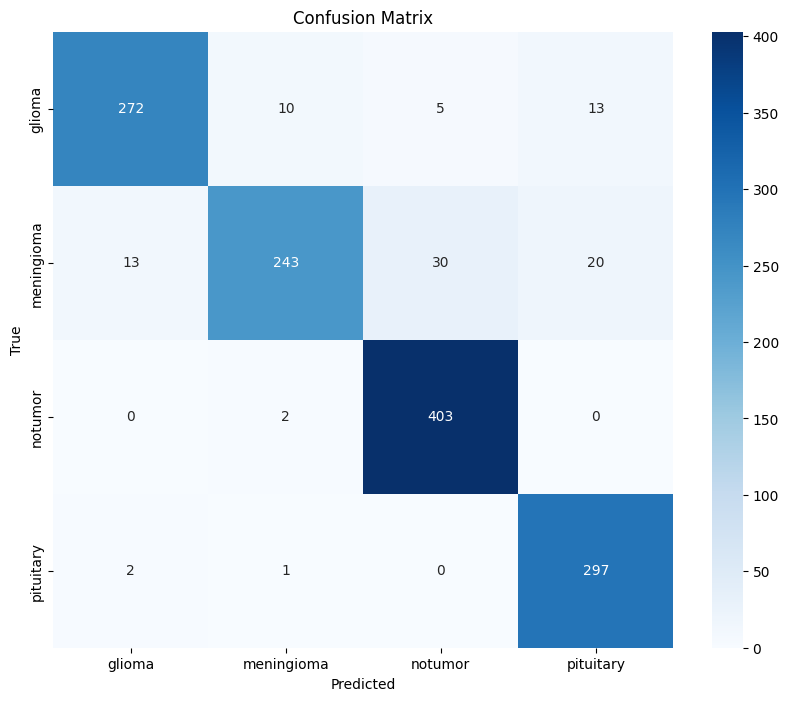

In [4]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False  # Important: keep data order for matching predictions
)

# --- Step 2: Predict on test data ---
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# --- Step 3: Get true labels ---
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# --- Step 4: Classification report ---
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# --- Step 5 (Optional): Confusion matrix ---
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

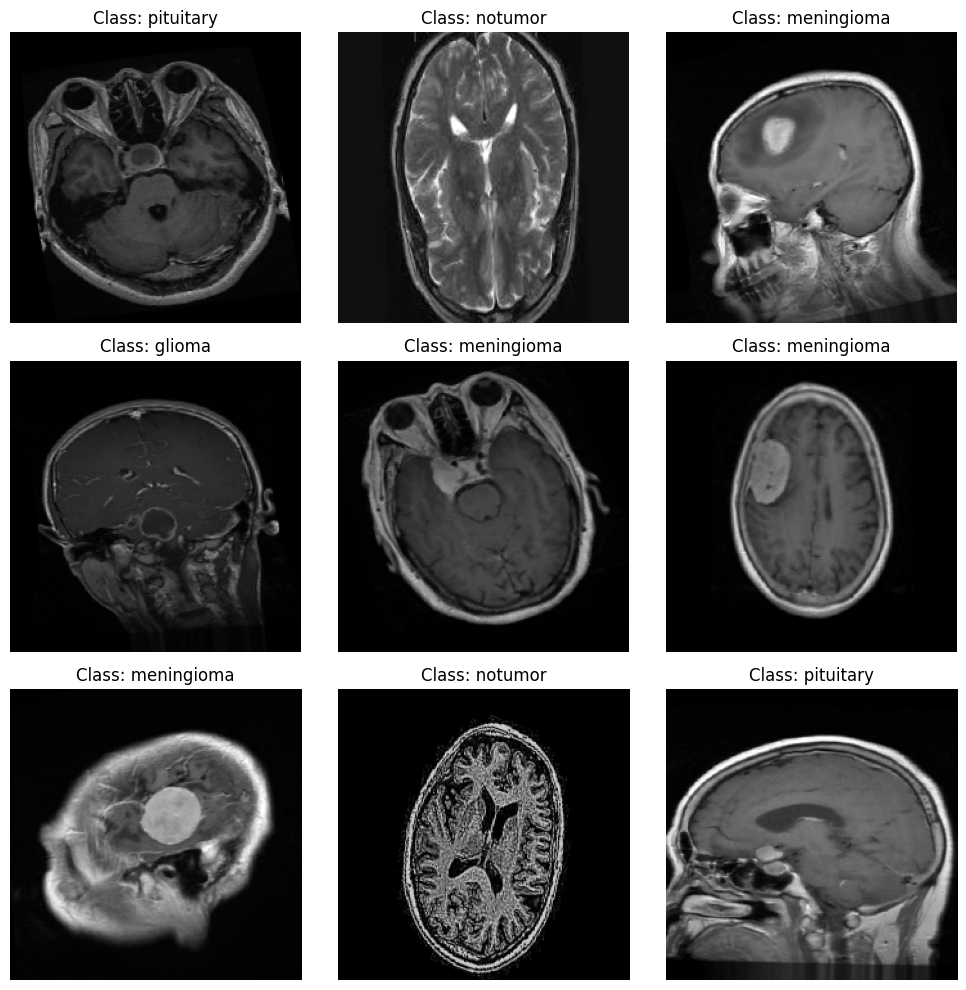

In [5]:
#Training Data
# Create a mapping from index to class name
class_indices = train_gen.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Get a batch of training images and labels
images, labels = next(train_gen)

# Plot the first 9 images with class names
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_index = np.argmax(labels[i])
    plt.title(f"Class: {index_to_class[class_index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0
